#### Import Libraries

In [100]:
import os
import numpy as np
import tensorflow.keras as keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

#### Data Loading

In [14]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls
!ls PetImages

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  82.0M      0  0:00:09  0:00:09 --:--:-- 92.6M
 ATP.ipynb		  'ist652_lab2_job (2).ipynb'   PetImages
 CDLA-Permissive-2.0.pdf   IST652_Lab3.ipynb	       'readme[1].txt'
'IST652 - Lab 1.ipynb'	  'IST652 - Lab 4.ipynb'
'IST652 - Lab 2.ipynb'	   kagglecatsanddogs_5340.zip
Cat  Dog


#### Filter out corrupted images

In [93]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


#### Generating Dataset

In [101]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23442 files belonging to 2 classes.
Using 18754 files for training.
Using 4688 files for validation.


#### Visualize the data


2024-03-29 11:20:17.615900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


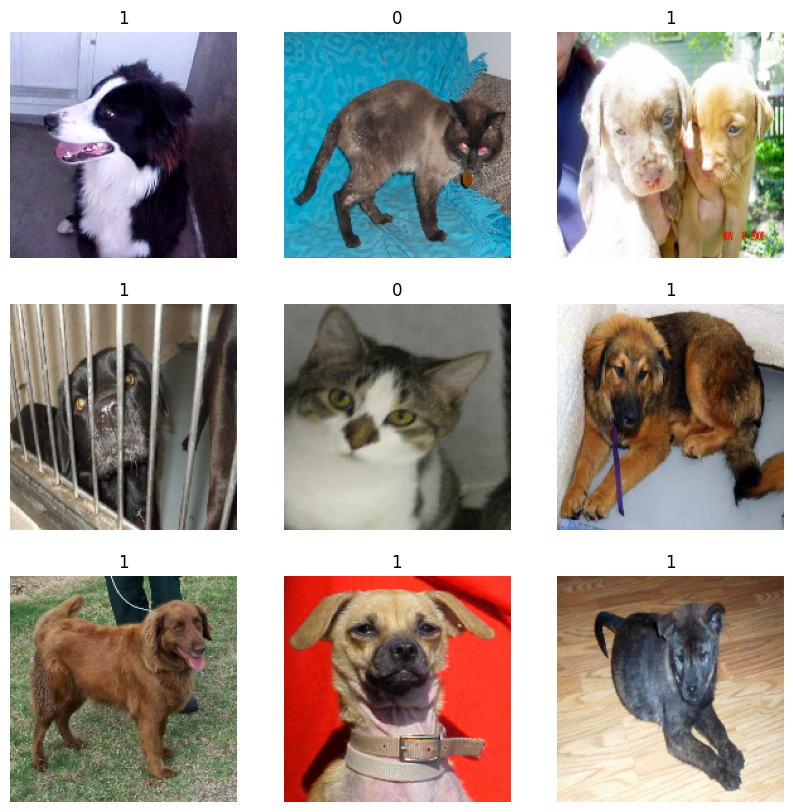

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#### Build a model

In [104]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

image_size = (180, 180)
batch_size = 128

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3),dtype='float32),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', dtype='float32'),
    Dense(1, activation='sigmoid', dtype='float32')  # Binary classification (cat vs dog)
])

# Compile the model
model.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

# Display model summary
model.summary()

ModuleNotFoundError: No module named 'tensorflow.keras.models'

#### Train the model

In [103]:
# Train the model

model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


AttributeError: Exception encountered when calling Dense.call().

[1mmodule 'keras.src.backend' has no attribute 'floatx'[0m

Arguments received by Dense.call():
  • inputs=tf.Tensor(shape=(None, 10368), dtype=float32)

### Run inference on new data

In [ ]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")